In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import copy

csv_data = pd.read_csv('Regular_Dataset.csv')
print(csv_data.shape)
filtered_data = pd.read_csv('Filtered_Dataset.csv')
print(filtered_data.shape)


(2636, 272)
(2636, 160)


In [4]:
data = pd.DataFrame()

categorical_columns = ["HomeTeam", "AwayTeam"]
unimportant_columns = ["Date", "FTHG", "FTAG", "FTR", "HTHG", "HTAG", "HTR", "Referee"]


# Everything else is a numerical column
numerical_columns = [column for column in csv_data.columns.values if column not in categorical_columns + unimportant_columns]

# Copy the numerical columns over
one_hot_encoded_columns = [pd.get_dummies(csv_data[column], prefix=column) for column in categorical_columns]

# One-hot encode the categorical columns
data = pd.concat([csv_data[numerical_columns]] + one_hot_encoded_columns, axis=1)

data = data.copy()

data['year'] = pd.to_datetime(csv_data['Date'], dayfirst=True).dt.year

data.head()

data['FTR'] = csv_data['FTR']

X = data.drop(columns=['FTR', 'year'])  # Features for training
y = data['FTR']  # Labels for training


X_train = X[data['year'] <= 2021]
Y_train = y[data['year'] <= 2021]
print(X_train.shape)

# Validation data
X_validation = X[data['year'] == 2022]
Y_validation = y[data['year'] == 2022]
print(X_validation.shape)

# Test data
X_test = X[data['year'].between(2023, 2024)]
Y_test = y[data['year'].between(2023, 2024)]
print(X_test.shape)

(1703, 322)
(361, 322)
(572, 322)


In [5]:
X = filtered_data.drop(columns=['FTR'])  # Features for training
y = filtered_data['FTR']  # Labels for training


X_train_filtered = X[0:1703]
Y_train_filtered  = y[0:1703]
print(X_train_filtered.shape)

# Validation data
X_validation_filtered  = X[1704:2065]
Y_validation_filtered  = y[1704:2065]
print(X_validation_filtered.shape)

# Test data
X_test_filtered  = X[2064:]
Y_test_filtered  = y[2064:]
print(X_test_filtered.shape)

(1703, 159)
(361, 159)
(572, 159)


In [6]:
from sklearn.metrics import ConfusionMatrixDisplay

def eval_model(model, X_train, Y_train, X_val, Y_val, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 3, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax, cmap='Blues')
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 3, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_val, Y_val, normalize='true', ax=ax, cmap='Blues')
    pred = model.predict(X_val)
    conf.ax_.set_title('Validation Set Performance: ' + str(sum(pred == Y_val)/len(Y_val)));
    ax = fig.add_subplot(1, 3, 3)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax, cmap='Blues')
    pred = model.predict(X_test)
    conf.ax_.set_title('Test Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between
        true and predicted values based on the metric chosen. """

    score = accuracy_score(y_true,y_predict)

    return score

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a
        decision tree regressor trained on the input data [X, y]. """

    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)
    regressor = DecisionTreeClassifier(random_state=42)
    params = {'max_depth':[10,15,16,17,18,19,20,25,30,40,50,70,100]}
    scoring_fnc = make_scorer(performance_metric)
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)
    grid = grid.fit(X, y)


    # Return the optimal model after fitting the data
    return grid.best_estimator_

(1703, 322) (361, 322) (572, 322)
Accuracy: 0.8479020979020979
              precision    recall  f1-score   support

           A       0.84      0.83      0.84       169
           D       0.83      0.85      0.84       130
           H       0.86      0.86      0.86       273

    accuracy                           0.85       572
   macro avg       0.84      0.85      0.84       572
weighted avg       0.85      0.85      0.85       572





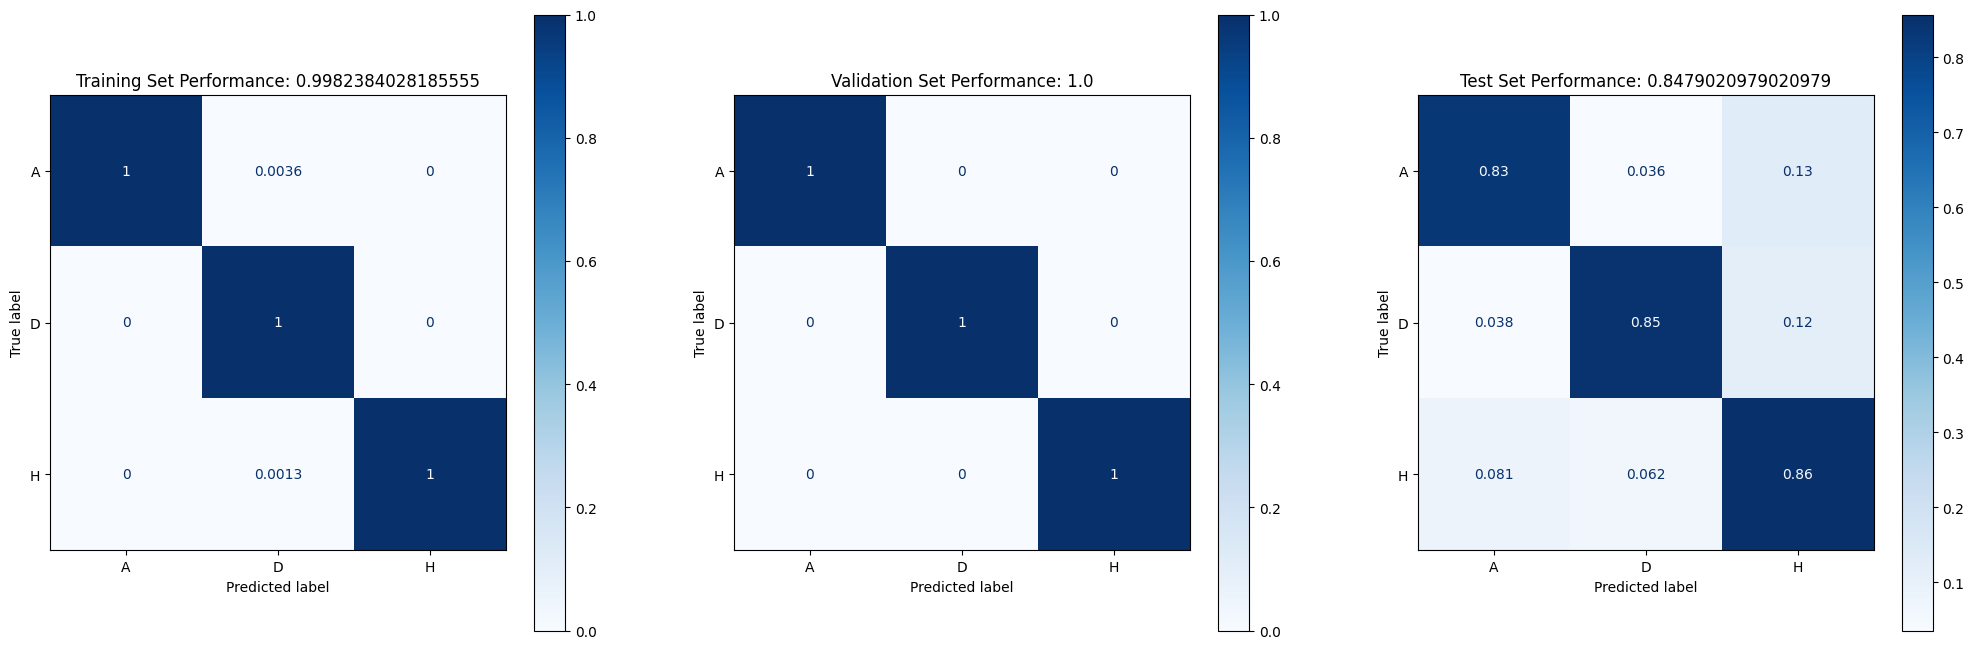

In [8]:
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC as SVM
from sklearn.metrics import accuracy_score

# standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_validation_std = scaler.transform(X_validation)
X_test_std = scaler.transform(X_test)
print(X_train_std.shape, X_validation_std.shape, X_test_std.shape)

model = SVM(random_state=42, kernel='linear', C=0.1)
model.fit(X_train_std, Y_train)
predictions = model.predict(X_test_std)
eval_model(model, X_train_std, Y_train, X_validation_std, Y_validation, X_test_std, Y_test)
print("Accuracy:", accuracy_score(Y_test, predictions))
print(classification_report(Y_test, model.predict(X_test_std)))
print("\n")


In [9]:
cls = fit_model(X_train_std, Y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(cls.get_params()['max_depth']))
cls.get_params()


Parameter 'max_depth' is 10 for the optimal model.


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

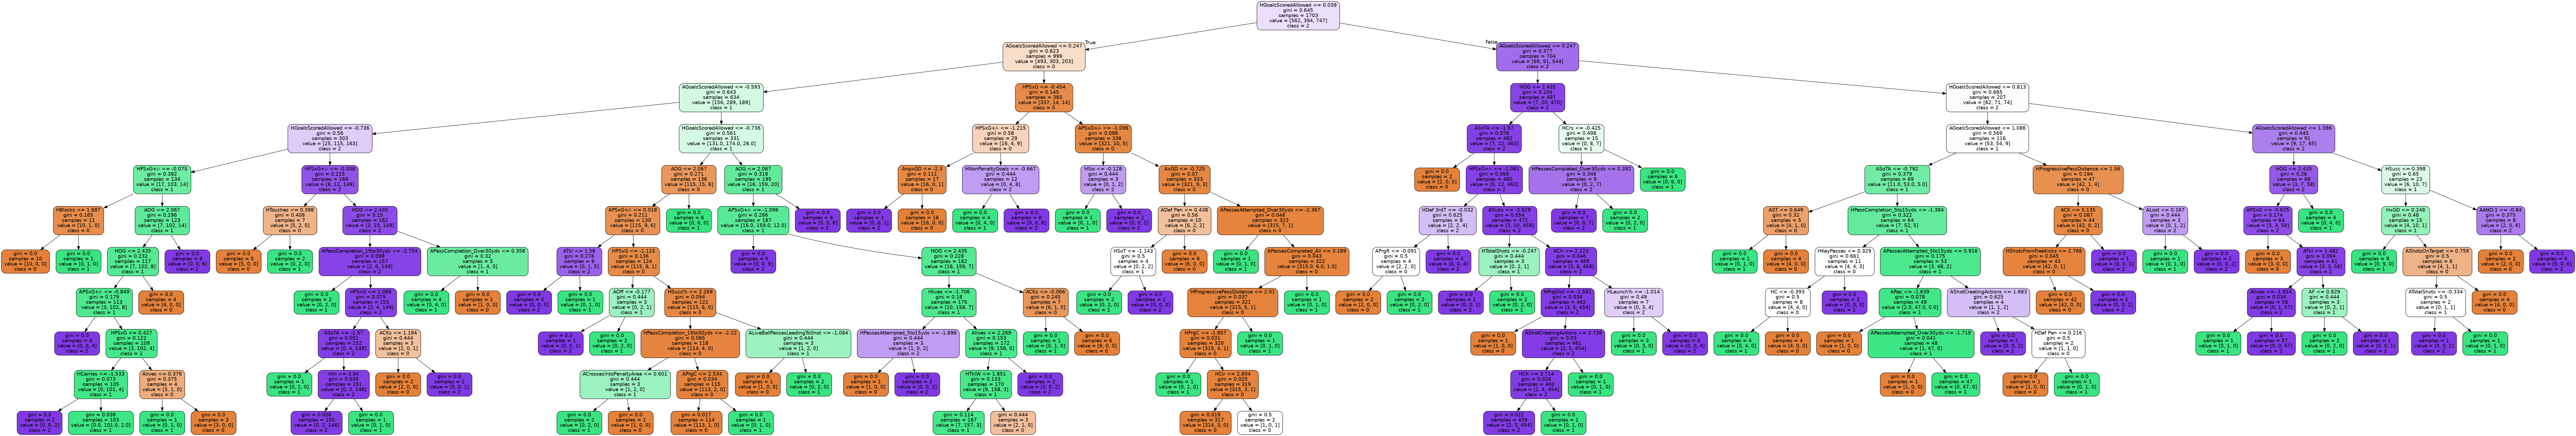

In [41]:
import pydot
from IPython.display import Image

(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

# Display the PNG image in a Jupyter notebook (if you're using one)
Image(filename='tree.png')


Accuracy: 0.7587412587412588
              precision    recall  f1-score   support

           A       0.71      0.76      0.73       169
           D       0.66      0.67      0.67       130
           H       0.84      0.80      0.82       273

    accuracy                           0.76       572
   macro avg       0.74      0.74      0.74       572
weighted avg       0.76      0.76      0.76       572





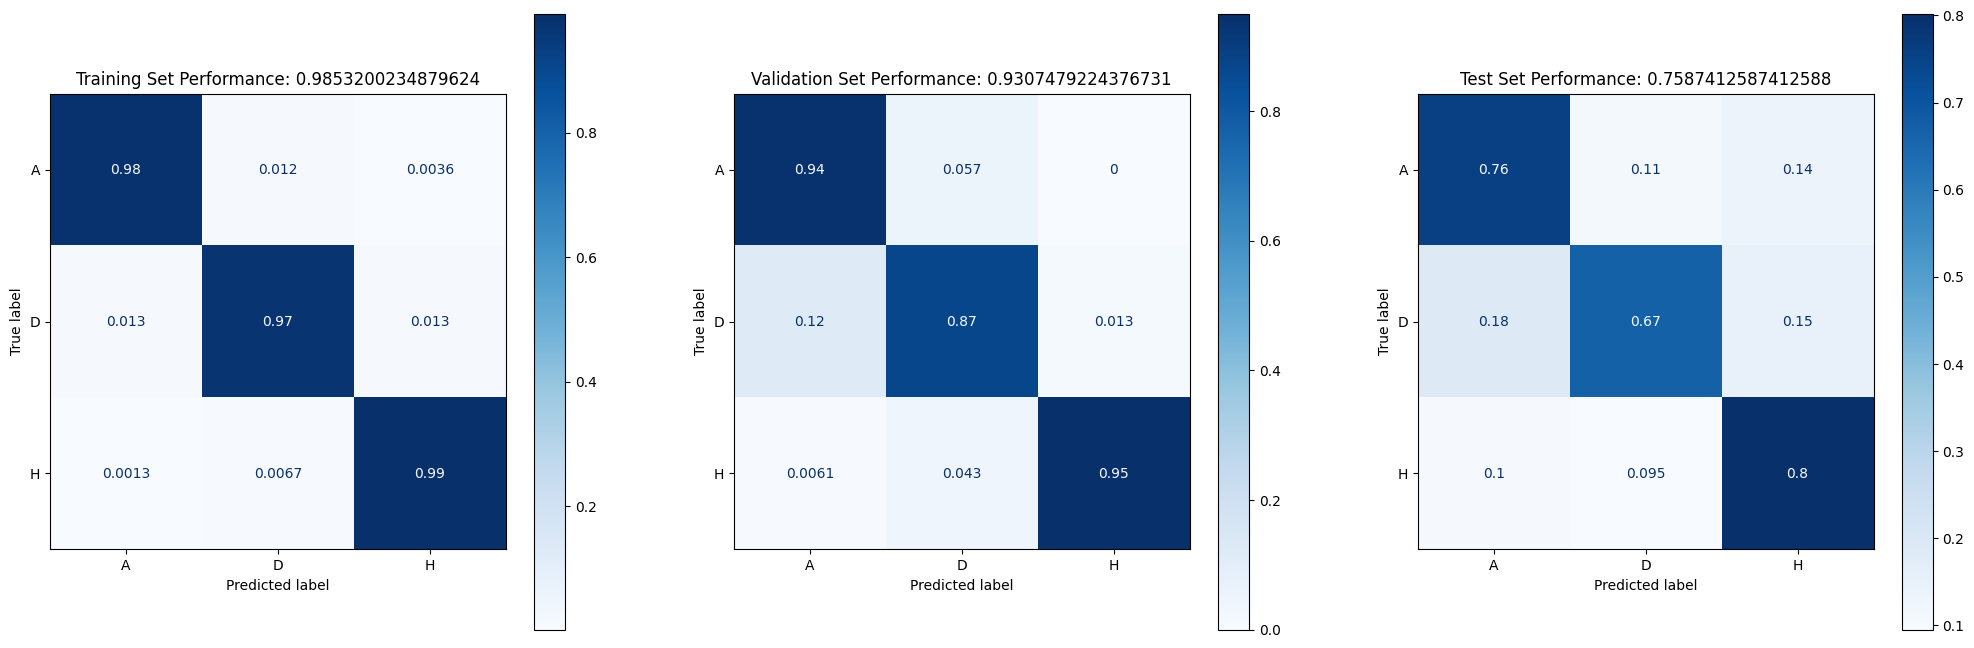

In [29]:
cls = DecisionTreeClassifier(max_depth=cls.get_params()['max_depth'])
cls.fit(X_train_std, Y_train)
predictions = cls.predict(X_test_std)

eval_model(cls, X_train_std, Y_train, X_validation_std, Y_validation, X_test_std, Y_test)
print("Accuracy:", accuracy_score(Y_test, predictions))
print(classification_report(Y_test, cls.predict(X_test_std)))
print("\n")

(1703, 159) (361, 159) (572, 159)
Accuracy: 0.9982517482517482
              precision    recall  f1-score   support

           A       1.00      0.99      1.00       169
           D       0.99      1.00      1.00       130
           H       1.00      1.00      1.00       273

    accuracy                           1.00       572
   macro avg       1.00      1.00      1.00       572
weighted avg       1.00      1.00      1.00       572





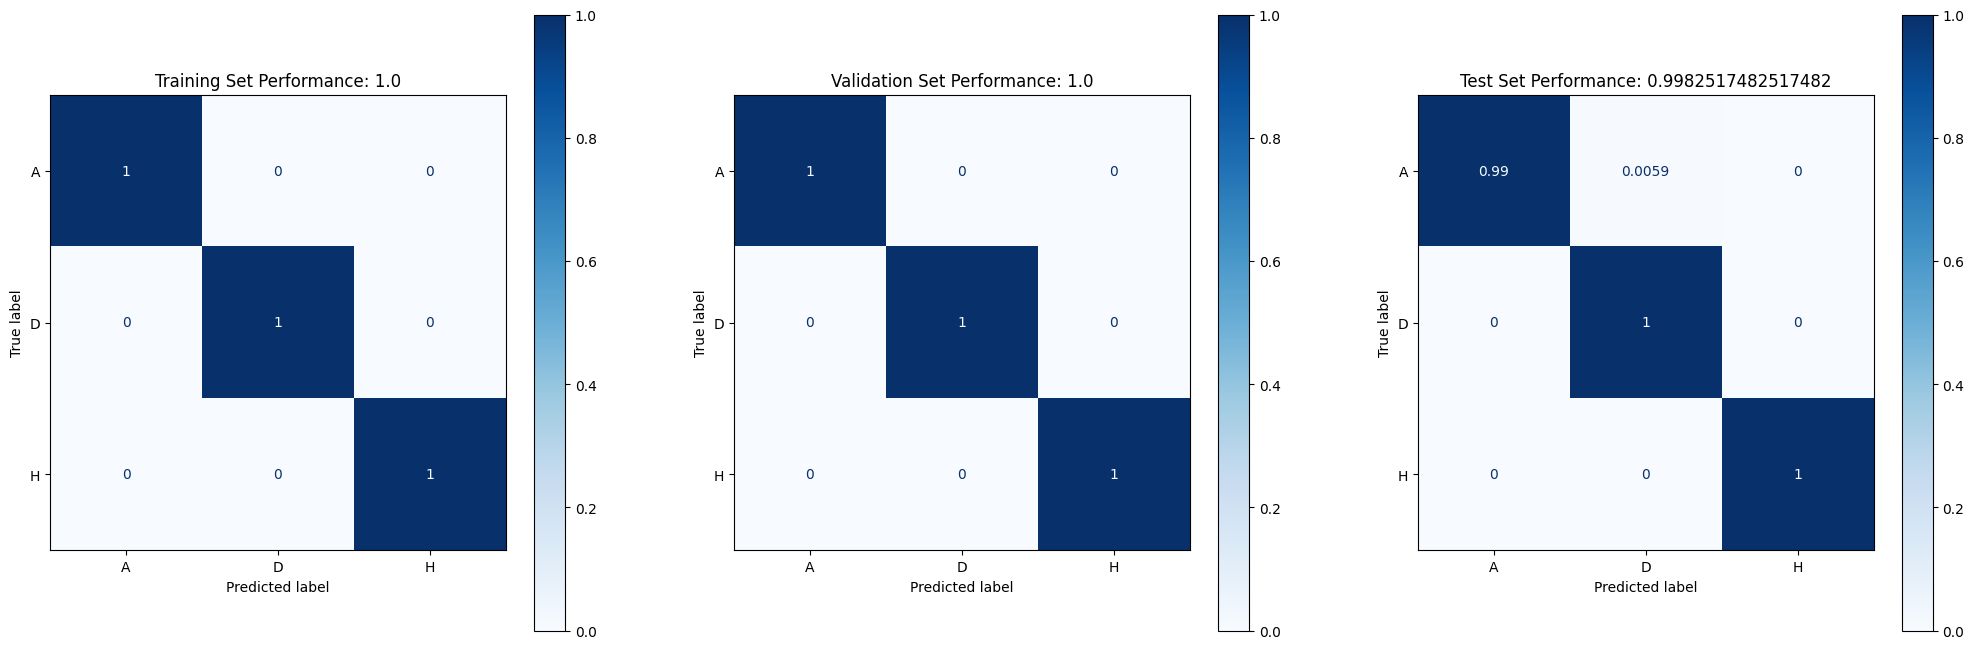

In [11]:
scaler.fit(X_train_filtered)
X_train_std_filtered = scaler.transform(X_train_filtered)
X_validation_std_filtered = scaler.transform(X_validation_filtered)
X_test_std_filtered = scaler.transform(X_test_filtered)
print(X_train_std_filtered.shape, X_validation_std_filtered.shape, X_test_std_filtered.shape)

model = SVM(random_state=42, kernel='linear', C=0.1)
model.fit(X_train_std_filtered, Y_train_filtered)
predictions = model.predict(X_test_std_filtered)
eval_model(model, X_train_std_filtered, Y_train_filtered, X_validation_std_filtered, Y_validation_filtered, X_test_std_filtered, Y_test_filtered)
print("Accuracy:", accuracy_score(Y_test_filtered, predictions))
print(classification_report(Y_test_filtered, model.predict(X_test_std_filtered)))
print("\n")

Accuracy: 0.9912587412587412
              precision    recall  f1-score   support

           A       1.00      0.99      0.99       169
           D       0.98      0.98      0.98       130
           H       0.99      1.00      0.99       273

    accuracy                           0.99       572
   macro avg       0.99      0.99      0.99       572
weighted avg       0.99      0.99      0.99       572





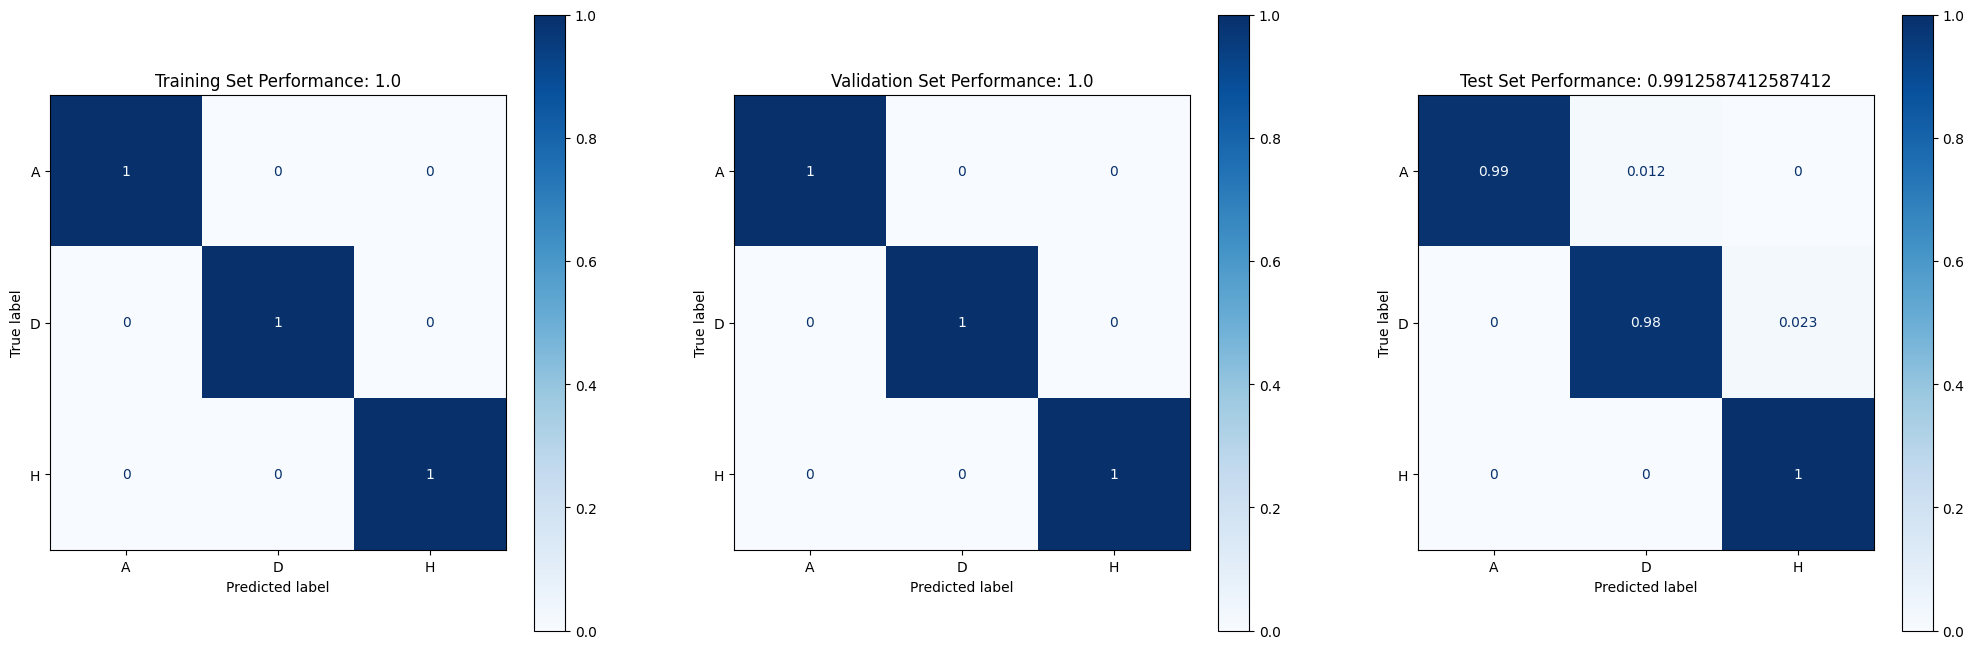

In [43]:
cls = DecisionTreeClassifier(max_depth=cls.get_params()['max_depth'])
cls.fit(X_train_std_filtered, Y_train)
predictions = cls.predict(X_test_std_filtered)

eval_model(cls, X_train_std_filtered, Y_train_filtered, X_validation_std_filtered, Y_validation_filtered, X_test_std_filtered, Y_test_filtered)
print("Accuracy:", accuracy_score(Y_test_filtered, predictions))
print(classification_report(Y_test_filtered, cls.predict(X_test_std_filtered)))
print("\n")

(1703, 192) (361, 192) (572, 192)
Accuracy (standardise): 0.7884615384615384
              precision    recall  f1-score   support

           A       0.74      0.82      0.78       169
           D       0.71      0.68      0.69       130
           H       0.86      0.82      0.84       273

    accuracy                           0.79       572
   macro avg       0.77      0.77      0.77       572
weighted avg       0.79      0.79      0.79       572





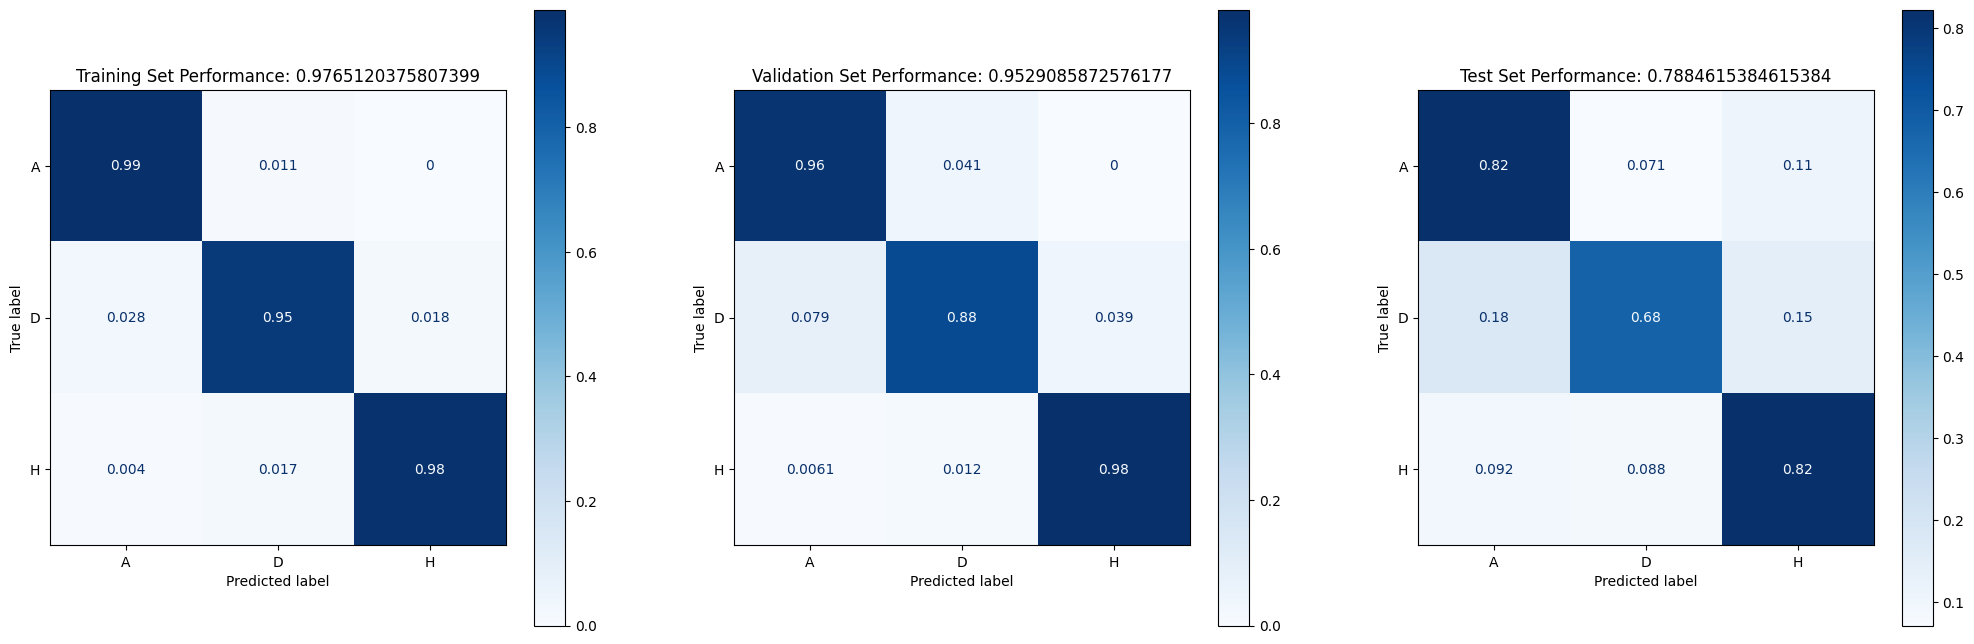

In [12]:
# PCA 
from sklearn import decomposition
pca = decomposition.PCA(random_state=42)
pca.fit(X_train_std)
transformed_train_std = pca.transform(X_train_std)
transformed_valid_std = pca.transform(X_validation_std)
transformed_test_std = pca.transform(X_test_std)


cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
top99 = np.where(cumulative_sum > 0.99)[0][0]
transformed_train_std = transformed_train_std[:, 0:top99]
transformed_valid_std = transformed_valid_std[:, 0:top99]
transformed_test_std = transformed_test_std[:, 0:top99]
print(transformed_train_std.shape, transformed_valid_std.shape, transformed_test_std.shape)

model = SVM(random_state=42, kernel='linear', C=0.1)
model.fit(transformed_train_std, Y_train)
predictions = model.predict(transformed_test_std)
eval_model(model, transformed_train_std, Y_train, transformed_valid_std, Y_validation, transformed_test_std, Y_test)
print("Accuracy (standardise):", accuracy_score(Y_test, predictions))
print(classification_report(Y_test, model.predict(transformed_test_std)))
print("\n")

# pca.fit(X_train_std_filtered)
# transformed_train_std_filtered = pca.transform(X_train_std_filtered)
# transformed_valid_std_filtered = pca.transform(X_validation_std_filtered)
# transformed_test_std_filtered = pca.transform(X_test_std_filtered)
# print(transformed_train_std_filtered.shape, transformed_valid_std_filtered.shape, transformed_test_std_filtered.shape)

# model = SVM(random_state=42, kernel='linear', C=0.1)
# model.fit(transformed_train_std_filtered, Y_train_filtered)
# predictions = model.predict(transformed_test_std_filtered)
# eval_model(model, transformed_train_std_filtered, Y_train_filtered, transformed_valid_std_filtered, Y_validation_filtered, transformed_test_std_filtered, Y_test_filtered)
# print("Accuracy (filtered):", accuracy_score(Y_test_filtered, predictions))
# print(classification_report(Y_test_filtered, model.predict(transformed_test_std_filtered)))
# print("\n")

Accuracy (standardise): 0.5681818181818182
              precision    recall  f1-score   support

           A       0.57      0.55      0.56       169
           D       0.33      0.42      0.36       130
           H       0.74      0.65      0.69       273

    accuracy                           0.57       572
   macro avg       0.54      0.54      0.54       572
weighted avg       0.59      0.57      0.58       572





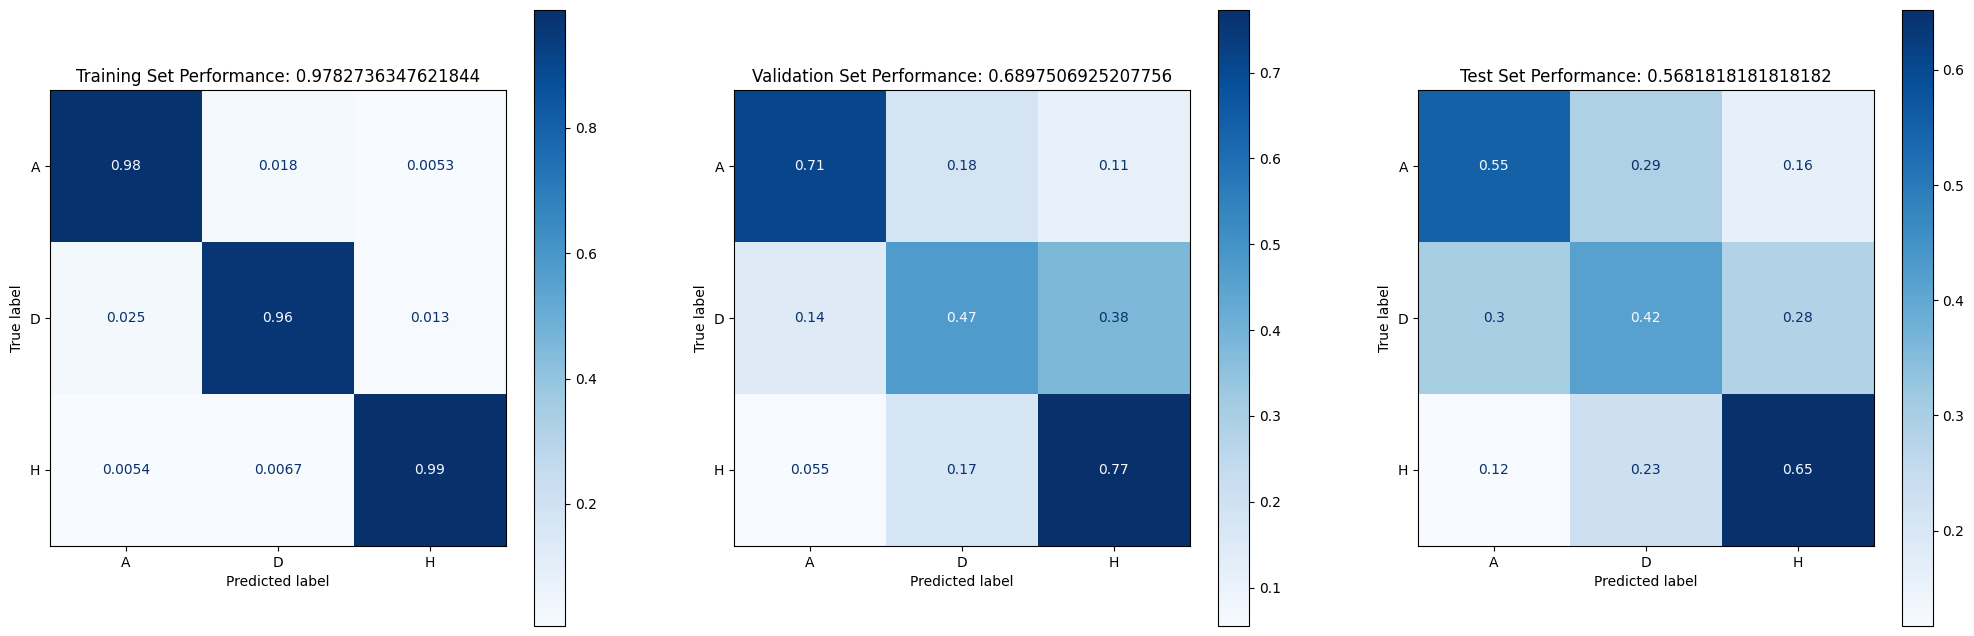

In [44]:
cls = DecisionTreeClassifier(max_depth=cls.get_params()['max_depth'])
cls.fit(transformed_train_std, Y_train)
predictions = cls.predict(transformed_test_std)

eval_model(cls, transformed_train_std, Y_train, transformed_valid_std, Y_validation, transformed_test_std, Y_test)
print("Accuracy (standardise):", accuracy_score(Y_test, predictions))
print(classification_report(Y_test, cls.predict(transformed_test_std)))
print("\n")


(1703, 2) (361, 2) (572, 2)
Accuracy (standardise): 0.5611888111888111
              precision    recall  f1-score   support

           A       0.60      0.82      0.69       169
           D       0.31      0.48      0.38       130
           H       0.88      0.44      0.58       273

    accuracy                           0.56       572
   macro avg       0.59      0.58      0.55       572
weighted avg       0.66      0.56      0.57       572





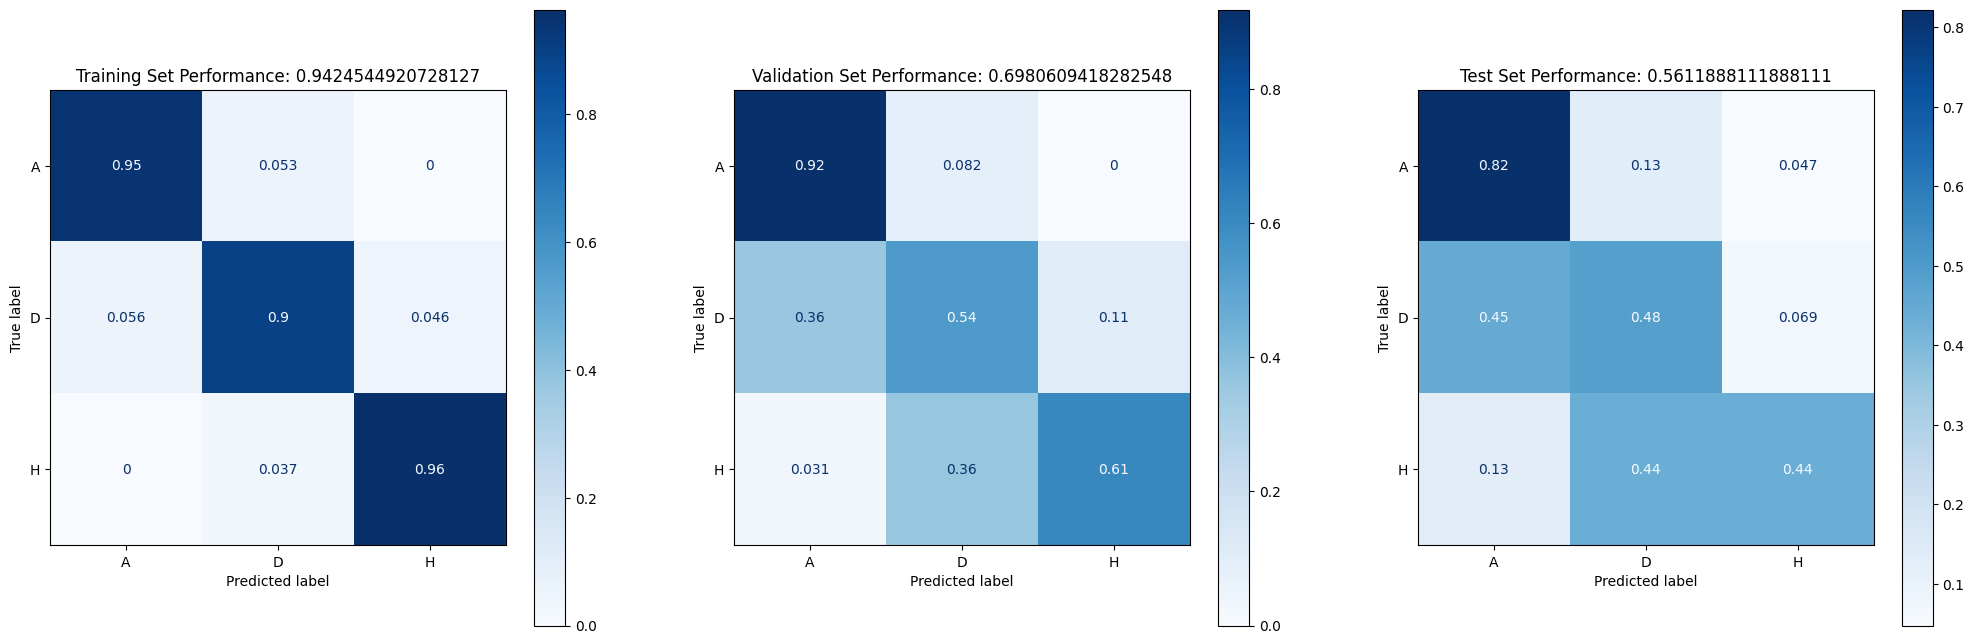

In [13]:
from sklearn import discriminant_analysis
LinearDiscriminantAnalysis = discriminant_analysis.LinearDiscriminantAnalysis().fit(X_train_std, Y_train)
transformed_lda_train_std = LinearDiscriminantAnalysis.transform(X_train_std)
transformed_lda_valid_std = LinearDiscriminantAnalysis.transform(X_validation_std)
transformed_lda_test_std = LinearDiscriminantAnalysis.transform(X_test_std)
print(transformed_lda_train_std.shape, transformed_lda_valid_std.shape, transformed_lda_test_std.shape)


model = SVM(random_state=42, kernel='linear', C=0.1)
model.fit(transformed_lda_train_std, Y_train)
predictions = model.predict(transformed_lda_test_std)
eval_model(model, transformed_lda_train_std, Y_train, transformed_lda_valid_std, Y_validation, transformed_lda_test_std, Y_test)
print("Accuracy (standardise):", accuracy_score(Y_test, predictions))
print(classification_report(Y_test, model.predict(transformed_lda_test_std)))
print("\n")

# LinearDiscriminantAnalysis = discriminant_analysis.LinearDiscriminantAnalysis().fit(X_train_std_filtered, Y_train)
# transformed_lda_train_std_filtered = LinearDiscriminantAnalysis.transform(X_train_std_filtered)
# transformed_lda_valid_std_filtered = LinearDiscriminantAnalysis.transform(X_validation_std_filtered)
# transformed_lda_test_std_filtered = LinearDiscriminantAnalysis.transform(X_test_std_filtered)
# print(transformed_lda_train_std_filtered.shape, transformed_lda_valid_std_filtered.shape, transformed_lda_test_std_filtered.shape)

# model = SVM(random_state=42, kernel='linear', C=0.1)
# model.fit(transformed_lda_train_std_filtered, Y_train_filtered)
# predictions = model.predict(transformed_lda_test_std_filtered)
# eval_model(model, transformed_lda_train_std_filtered, Y_train_filtered, transformed_lda_valid_std_filtered, Y_validation_filtered, transformed_lda_test_std_filtered, Y_test_filtered)
# print("Accuracy (filtered):", accuracy_score(Y_test_filtered, predictions))
# print(classification_report(Y_test_filtered, model.predict(transformed_lda_test_std_filtered)))
# print("\n")

Accuracy (standardise): 0.548951048951049
              precision    recall  f1-score   support

           A       0.54      0.84      0.66       169
           D       0.29      0.38      0.33       130
           H       0.87      0.45      0.59       273

    accuracy                           0.55       572
   macro avg       0.57      0.56      0.53       572
weighted avg       0.64      0.55      0.55       572





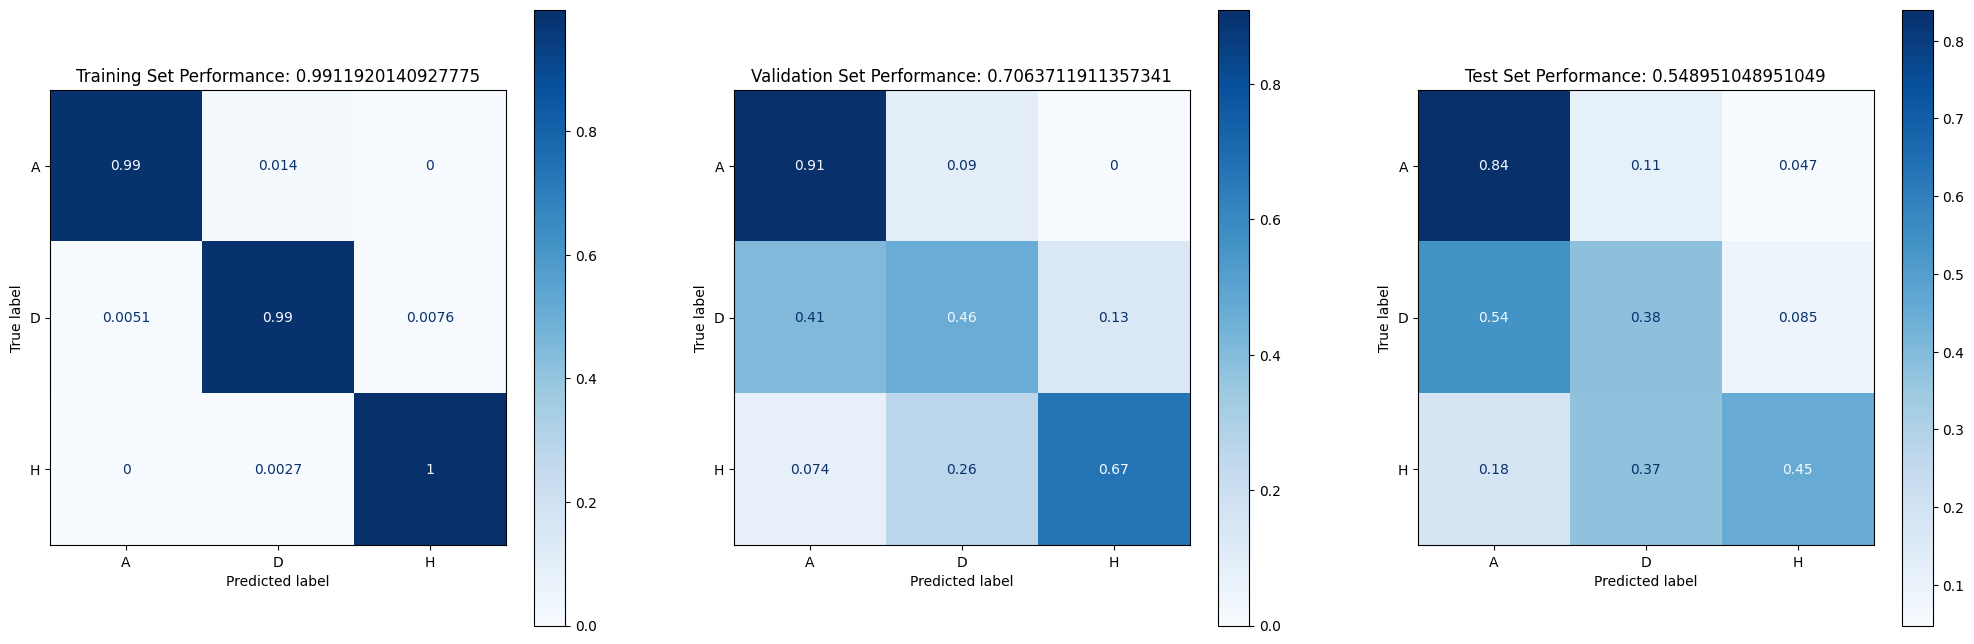

In [45]:
cls = DecisionTreeClassifier(max_depth=cls.get_params()['max_depth'])
cls.fit(transformed_lda_train_std, Y_train)
predictions = cls.predict(transformed_lda_test_std)

eval_model(cls, transformed_lda_train_std, Y_train, transformed_lda_valid_std, Y_validation, transformed_lda_test_std, Y_test)
print("Accuracy (standardise):", accuracy_score(Y_test, predictions))
print(classification_report(Y_test, cls.predict(transformed_lda_test_std)))
print("\n")


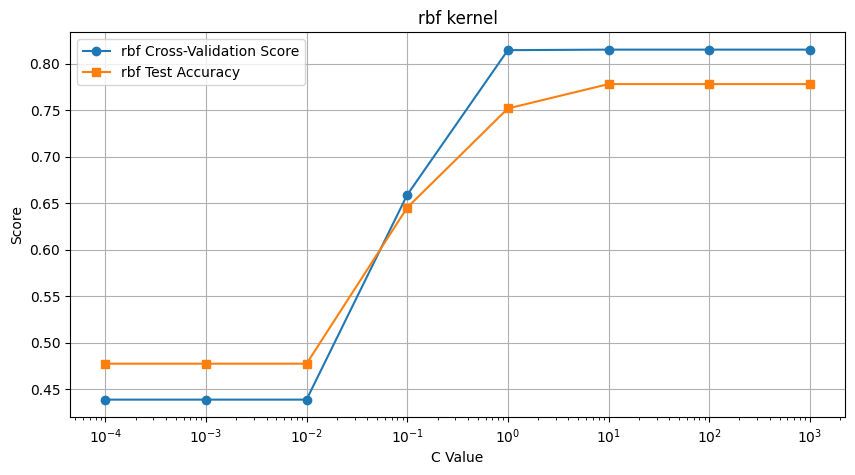

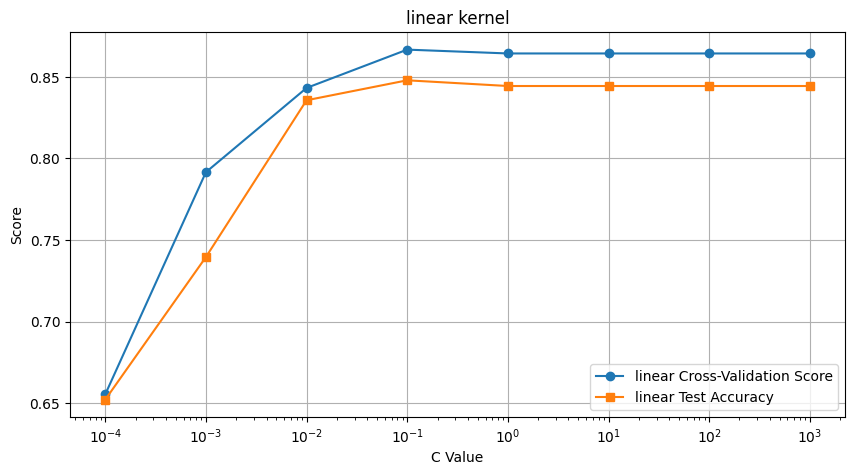

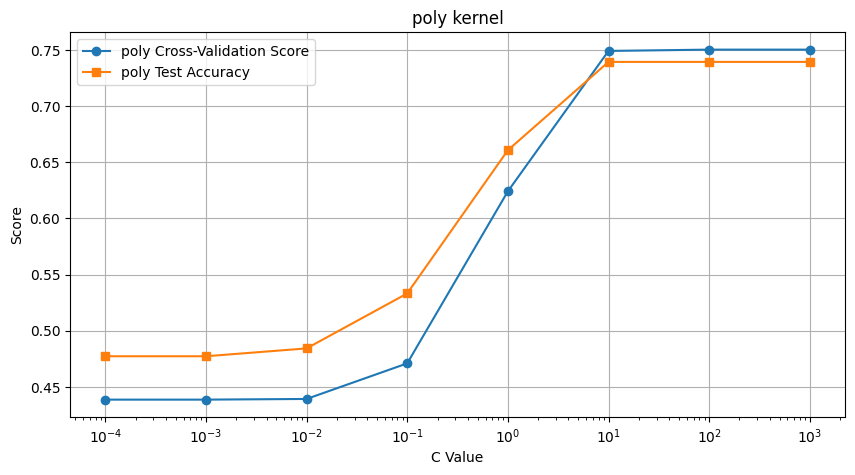

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
def plot(kernel):
    cv_scores = []
    test_accuracies = []

    for C in C_values:
        svc = SVC(C=C, kernel=kernel)
        cv_score = np.mean(cross_val_score(svc, X_train_std, Y_train, cv=2))
        cv_scores.append(cv_score)

        svc.fit(X_train_std, Y_train)
        test_accuracy = svc.score(X_test_std, Y_test)
        test_accuracies.append(test_accuracy)

    plt.figure(figsize=(10, 5))
    plt.plot(C_values, cv_scores, label=f'{kernel} Cross-Validation Score', marker='o')
    plt.plot(C_values, test_accuracies, label=f'{kernel} Test Accuracy', marker='s')
    plt.xscale('log')
    plt.xlabel('C Value')
    plt.ylabel('Score')
    plt.title(f'{kernel} kernel')
    plt.legend()
    plt.grid(True)
    plt.show()

plot(kernel='rbf')
plot(kernel='linear')
plot(kernel='poly')


SVM (Regular Dataset)

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
C_values = np.arange(1, 100, 1)
gamma_values = np.arange(0.01, 0.0001, -0.0001)

param_grid = [
    {
    'kernel': ['linear'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }]

svm = SVC(probability=True)
svm_grid_search = GridSearchCV(svm, param_grid, cv=2)
svm_grid_search.fit(X_train_std, Y_train)
svm_best_parameters = svm_grid_search.best_params_
svm_best_score = svm_grid_search.best_score_
svm_best_model = svm_grid_search.best_estimator_

 
print(f"Best Parameters: {svm_best_parameters}")
print(f"Best Score: {svm_best_score}")

Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Best Score: 0.8667192146218479


              precision    recall  f1-score   support

           A       0.84      0.83      0.84       169
           D       0.83      0.85      0.84       130
           H       0.86      0.86      0.86       273

    accuracy                           0.85       572
   macro avg       0.84      0.85      0.84       572
weighted avg       0.85      0.85      0.85       572





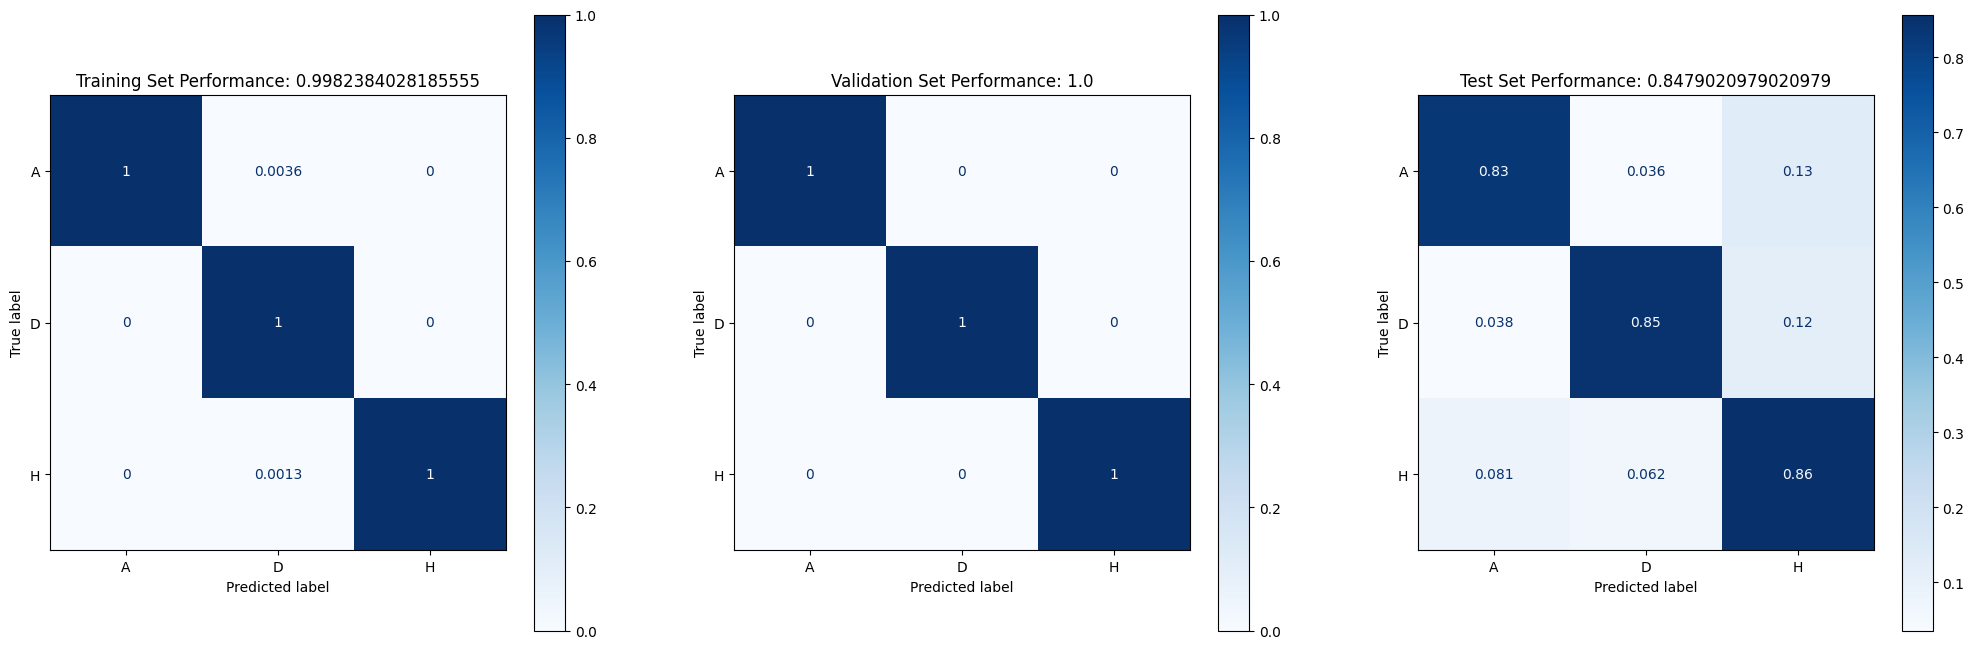

In [24]:
eval_model(svm_best_model, X_train_std, Y_train, X_validation_std, Y_validation, X_test_std, Y_test)
print(classification_report(Y_test, svm_best_model.predict(X_test_std)))
print("\n")


SVM (Filtered Dataset)

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
C_values = np.arange(1, 100, 1)
gamma_values = np.arange(0.01, 0.0001, -0.0001)

param_grid = [
    {
    'kernel': ['linear'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }]

svm = SVC(probability=True)
svm_grid_search = GridSearchCV(svm, param_grid, cv=2)
svm_grid_search.fit(X_train_std_filtered, Y_train_filtered)
svm_best_parameters = svm_grid_search.best_params_
svm_best_score = svm_grid_search.best_score_
svm_best_model = svm_grid_search.best_estimator_

 
print(f"Best Parameters: {svm_best_parameters}")
print(f"Best Score: {svm_best_score}")

Best Parameters: {'C': 1, 'kernel': 'linear'}
Best Score: 0.9730046948356808


              precision    recall  f1-score   support

           A       1.00      1.00      1.00       169
           D       1.00      1.00      1.00       130
           H       1.00      1.00      1.00       273

    accuracy                           1.00       572
   macro avg       1.00      1.00      1.00       572
weighted avg       1.00      1.00      1.00       572





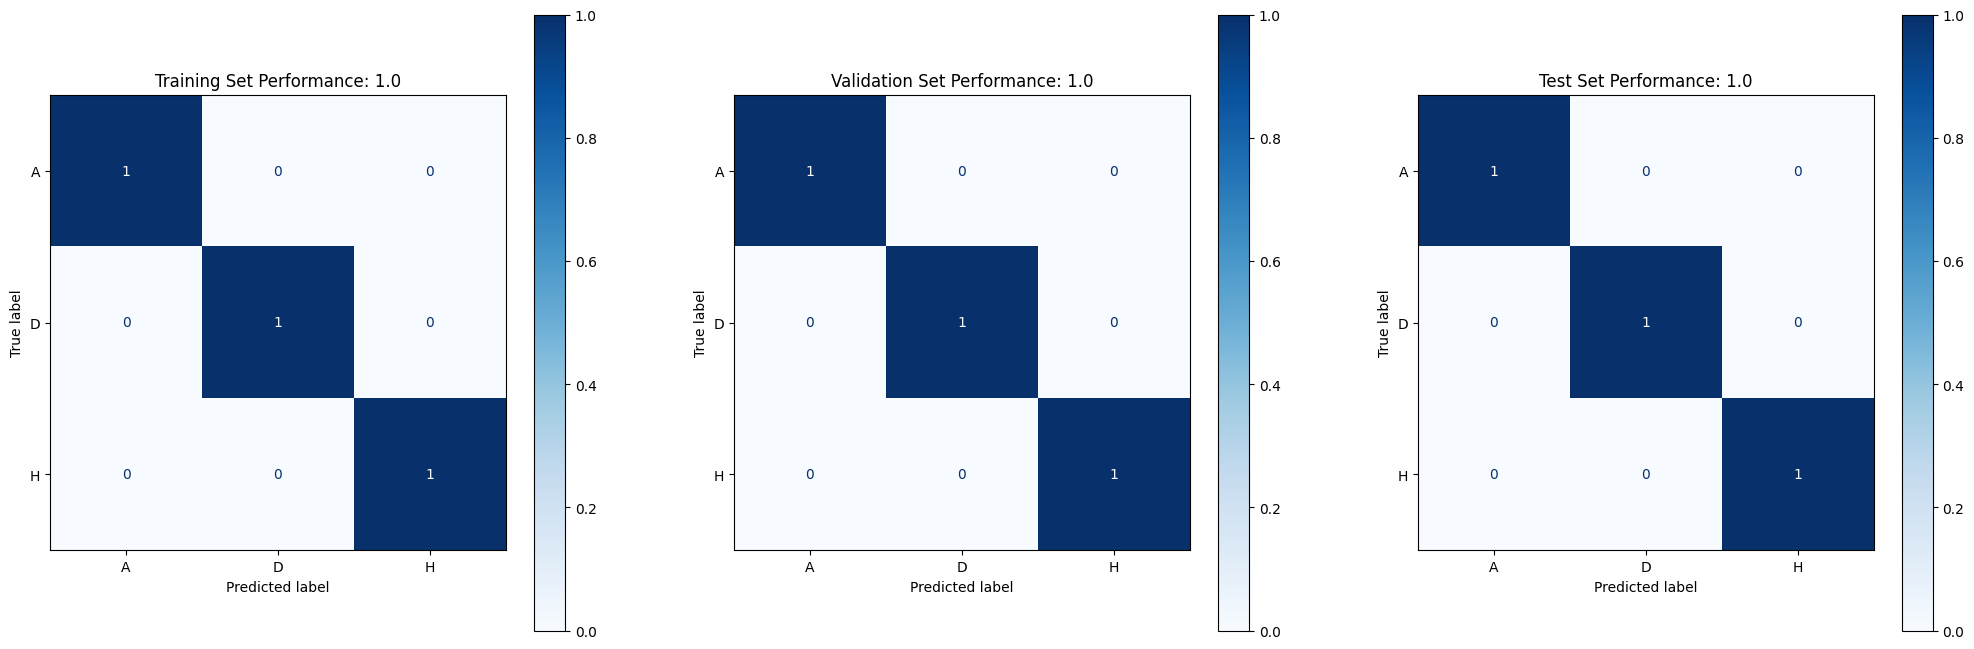

In [34]:
eval_model(svm_best_model, X_train_std_filtered, Y_train_filtered, X_validation_std_filtered, Y_validation_filtered, X_test_std_filtered, Y_test_filtered)
print(classification_report(Y_test_filtered, svm_best_model.predict(X_test_std_filtered)))
print("\n")

SVM (PCA Dataset)

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
C_values = np.arange(1, 100, 1)
gamma_values = np.arange(0.01, 0.0001, -0.0001)

param_grid = [
    {
    'kernel': ['linear'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }]

svm = SVC(probability=True)
svm_grid_search = GridSearchCV(svm, param_grid, cv=2)
svm_grid_search.fit(transformed_train_std, Y_train)
svm_best_parameters = svm_grid_search.best_params_
svm_best_score = svm_grid_search.best_score_
svm_best_model = svm_grid_search.best_estimator_

 
print(f"Best Parameters: {svm_best_parameters}")
print(f"Best Score: {svm_best_score}")

Best Parameters: {'C': 0.01, 'kernel': 'linear'}
Best Score: 0.8361738192571015


              precision    recall  f1-score   support

           A       0.80      0.83      0.81       169
           D       0.85      0.76      0.80       130
           H       0.85      0.87      0.86       273

    accuracy                           0.83       572
   macro avg       0.83      0.82      0.83       572
weighted avg       0.83      0.83      0.83       572





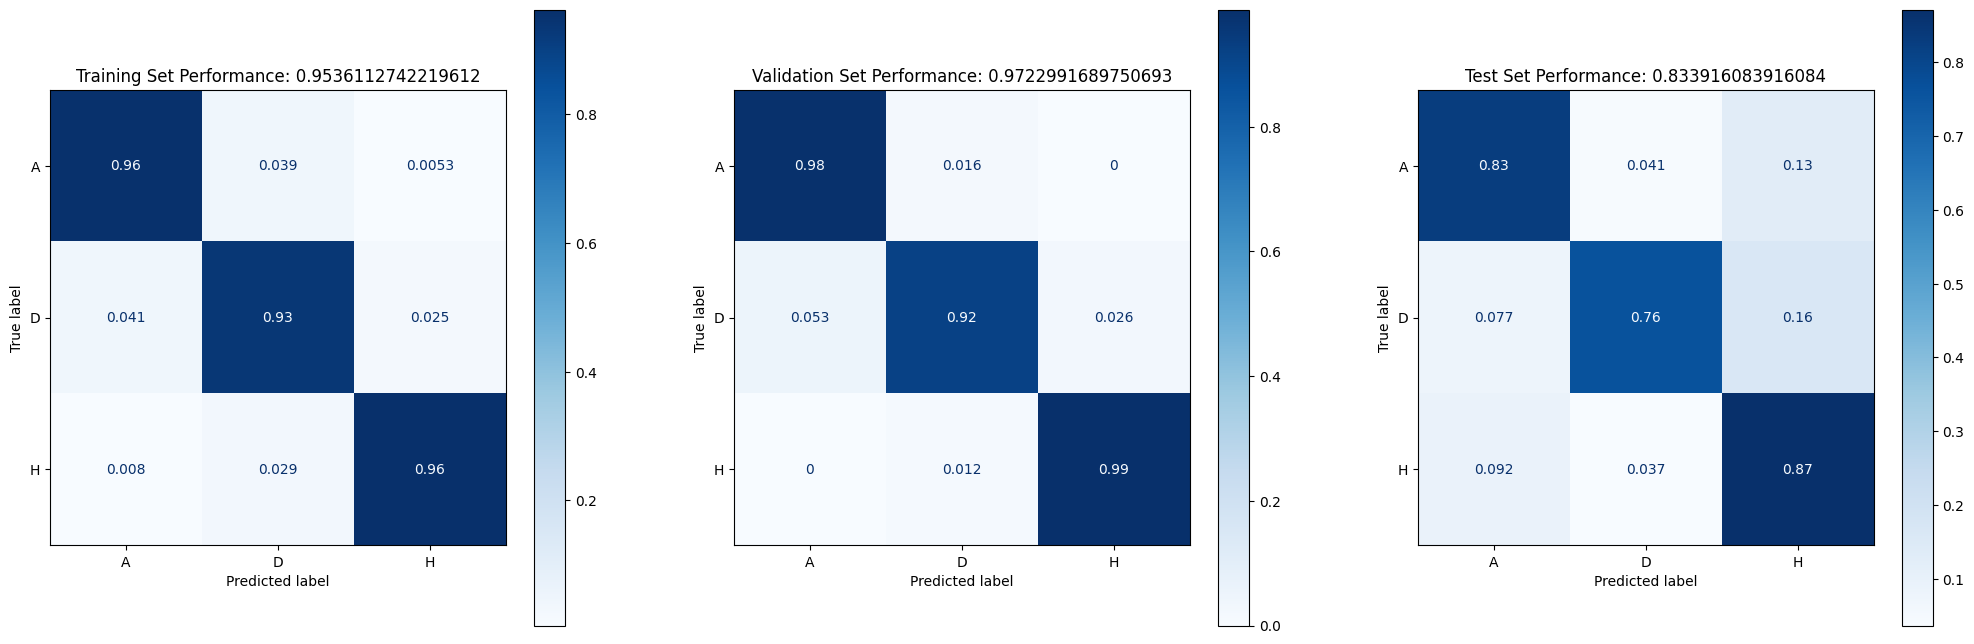

In [30]:
eval_model(svm_best_model, transformed_train_std, Y_train, transformed_valid_std, Y_validation, transformed_test_std, Y_test)
print(classification_report(Y_test, svm_best_model.predict(transformed_test_std)))
print("\n")

SVM (LDA Dataset)

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
C_values = np.arange(1, 100, 1)
gamma_values = np.arange(0.01, 0.0001, -0.0001)

param_grid = [
    {
    'kernel': ['linear'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }]

svm = SVC(probability=True)
svm_grid_search = GridSearchCV(svm, param_grid, cv=2)
svm_grid_search.fit(transformed_lda_train_std, Y_train)
svm_best_parameters = svm_grid_search.best_params_
svm_best_score = svm_grid_search.best_score_
svm_best_model = svm_grid_search.best_estimator_

 
print(f"Best Parameters: {svm_best_parameters}")
print(f"Best Score: {svm_best_score}")

Best Parameters: {'C': 1, 'kernel': 'linear'}
Best Score: 0.9442053811312844


              precision    recall  f1-score   support

           A       0.59      0.83      0.69       169
           D       0.32      0.48      0.38       130
           H       0.88      0.44      0.59       273

    accuracy                           0.56       572
   macro avg       0.59      0.58      0.55       572
weighted avg       0.66      0.56      0.57       572





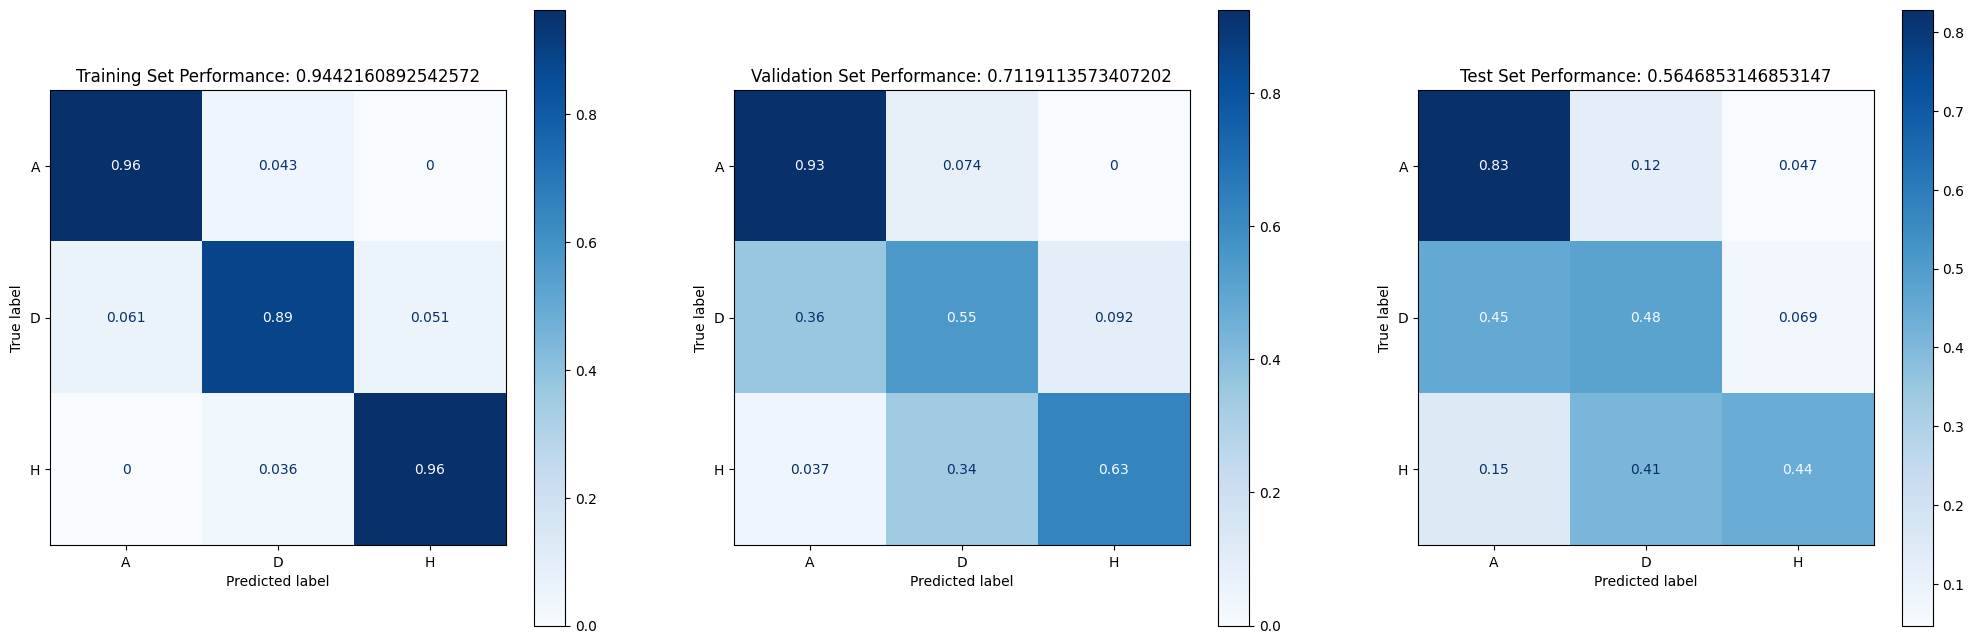

In [38]:
eval_model(svm_best_model, transformed_lda_train_std, Y_train, transformed_lda_valid_std, Y_validation, transformed_lda_test_std, Y_test)
print(classification_report(Y_test, svm_best_model.predict(transformed_lda_test_std)))
print("\n")